In [24]:
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from skimage import feature, morphology, measure, transform, filters
from skimage.transform import probabilistic_hough_line
from sklearn.decomposition import PCA
from scipy.ndimage import uniform_filter
project_id ='geothermalrevamp'

ee.Initialize(project=project_id)
print("Authentication successful and Earth Engine initialized.")

Authentication successful and Earth Engine initialized.


In [25]:
roi = ee.Geometry.Rectangle([119.5, -9, 123.0, -8.15])

In [26]:
def mask_l9_sr(image):
    # 1. Masks
    qa_mask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturation_mask = image.select('QA_RADSAT').eq(0)

    # 2. Scaling
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)

    image_scaled = image.addBands(optical_bands, None, True) \
                    .addBands(thermal_bands, None, True) \
                    .updateMask(qa_mask) \
                    .updateMask(saturation_mask)

    # 3. Basic Bands Calculation
    lst_c = image_scaled.select('ST_B10').subtract(273.15).rename('LST_Celsius')
    ndvi = image_scaled.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    ndwi = image_scaled.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')

    # Return only pixel-based bands. SMI and DEM come later.
    return image_scaled.addBands(lst_c).addBands(ndvi).addBands(ndwi)

In [27]:
# 1. Collection & Composite
l9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filterBounds(roi) \
    .filterDate('2021-11-30', '2025-10-31') \
    .filter(ee.Filter.calendarRange(3, 10, 'month')) \
    .filter(ee.Filter.lt('CLOUD_COVER', 20)) \
    .map(mask_l9_sr)

# Create the Median base
base_composite = l9.median().clip(roi)

# 2. Gap Fill (Focal Mean)
backup = base_composite.focal_mean(radius=3, units='pixels')
backup2 = base_composite.focal_mean(radius=25, units='pixels')
final_composite = base_composite.unmask(backup).unmask(backup2)

# --- NEW: Calculate SMI on the Final Composite ---
# We calculate Min/Max ONCE on the clean image, not 500 times.

# A. Get Min/Max LST
stats_lst = final_composite.reduceRegion(
    reducer=ee.Reducer.min().combine(ee.Reducer.max(), sharedInputs=True),
    geometry=roi,
    scale=90,
    bestEffort=True,
    maxPixels=1e9,
    tileScale=4
)
lst_min_val = ee.Number(stats_lst.get('LST_Celsius_min'))
lst_max_val = ee.Number(stats_lst.get('LST_Celsius_max'))

# B. Calculate SMI
smi = final_composite.expression(
    '(LST_max - LST_Celsius) / (LST_max - LST_min)',
    {
        'LST_Celsius': final_composite.select('LST_Celsius'),
        'LST_min': lst_min_val,
        'LST_max': lst_max_val
    }
).rename('SMI')

# --- NEW: Add DEM ---
dem = ee.Image('NASA/NASADEM_HGT/001').select('elevation').clip(roi).rename('DEM')
dem_stats = dem.reduceRegion(reducer = ee.Reducer.min().combine(ee.Reducer.max(), sharedInputs=True), scale=90, bestEffort=True, maxPixels=1e9, tileScale=4)

dem_min = ee.Number(dem_stats.get('DEM_min'))
dem_max = ee.Number(dem_stats.get('DEM_max'))
# C. Pack everything into one final image for visualization/export
final_map_layer = final_composite.addBands(smi).addBands(dem)

In [28]:
Map = geemap.Map()
Map.centerObject(roi, 10)

vis_rgb = {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0.0, 'max': 0.25}
vis_lst = {'min': 18, 'max': 45, 'palette': ['blue', 'cyan', 'green', 'yellow', 'red']}
vis_ndvi = {'min': 0, 'max': 0.9, 'palette': ['white', 'green']}
vis_smi = {'min': 0, 'max': 1, 'palette': ['blue', 'yellow', 'red']} # Wet to Dry
vis_dem = {'min': dem_min, 'max': dem_max, 'palette': ['white', 'black']}

#Map.addLayer(final_composite, vis_rgb, 'Landsat 9 RGB')
Map.addLayer(final_map_layer.select('NDVI'), vis_ndvi, 'NDVI')
Map.addLayer(final_map_layer.select('NDWI'), {'min':-0.7, 'max':0.4, 'palette':['white', 'blue']}, 'NDWI')
#Map.addLayer(final_map_layer.select('LST_Celsius'), vis_lst, 'LST (Celsius)')
#Map.addLayer(final_map_layer.select('SMI'), vis_smi, 'SMI (Soil Moisture)')
#Map.addLayer(final_map_layer.select('DEM'), vis_dem, 'DEM')

Map

Map(center=[-8.578782889017356, 121.25000000000004], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
#Simply use DEM/TPI for now
dem = ee.Image("NASA/NASADEM_HGT/001").select('elevation').clip(roi)

kernel_size = 2
kernel = ee.Kernel.square(radius=kernel_size, units='pixels')

stats = dem.reduceNeighborhood(
    reducer=ee.Reducer.mean().combine(
        reducer2=ee.Reducer.min(), sharedInputs=True
    ).combine(
        reducer2=ee.Reducer.max(), sharedInputs=True
    ),
    kernel=kernel
)

mean_band = stats.select('elevation_mean')
min_band = stats.select('elevation_min')
max_band = stats.select('elevation_max')

tpi = (mean_band.subtract(min_band)).divide(max_band.subtract(min_band)).rename('TPI_User_Formula')


Data received. Shape: (397, 1625, 6)
Running Principal Component Analysis...


(np.float64(-0.5), np.float64(1624.5), np.float64(396.5), np.float64(-0.5))

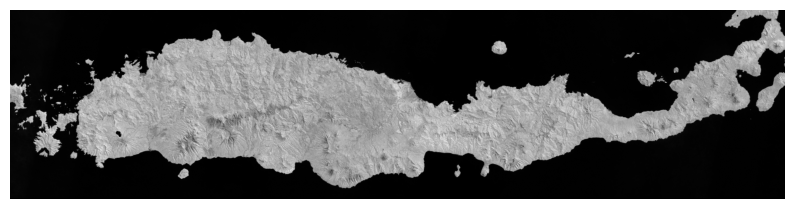

In [30]:
# Perform Principal Component Analysis (PCA) on the optical bands.
# Note: PCA is performed on the multispectral optical bands (2-7).
# Band 8 (panchromatic) is not used here as it has a different resolution and
# PCA is typically used to reduce dimensionality of multi-band imagery.

# 1. Select the optical bands from the composite image.
# Using bands 2-7 for PCA. These are Blue, Green, Red, NIR, SWIR1, SWIR2.
bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
l9_stack = final_composite.select(bands)
#bandstacking

img_array = geemap.ee_to_numpy(l9_stack, region=roi, scale=240)
print(f"Data received. Shape: {img_array.shape}")

# 3. Perform PCA (The Math Part)
print("Running Principal Component Analysis...")

rows, cols, depth = img_array.shape

# A. Flatten the image: (Pixels, Bands) -> (N, 6)
flat_img = img_array.reshape(rows * cols, depth)

# B. Handle NaNs (Mask them out so PCA doesn't crash)
# We only want to run PCA on valid pixels
valid_mask = ~np.isnan(flat_img).any(axis=1)
valid_pixels = flat_img[valid_mask]

# C. Run PCA using scikit-learn
pca = PCA(n_components=1) # We only need PC1 (Maximum Variance)
pc1_pixels = pca.fit_transform(valid_pixels)

# D. Reconstruct the Image
# Create an empty array full of zeros/NaNs
pc1_image = np.zeros((rows * cols), dtype=np.float32)
# Fill in the calculated PC1 values at the valid locations
pc1_image[valid_mask] = pc1_pixels[:, 0]
# Reshape back to (Height, Width)
pc1_image = pc1_image.reshape(rows, cols)

plt.figure(figsize=(10, 10))
plt.imshow(pc1_image, cmap='gray')
plt.axis('off')


In [34]:
def normalize_to_byte(array):
    """
    Normalizes a DEM array to 0-255 (UInt8) using min-max scaling.
    """
    # 1. Replace NaNs with 0 (safe fallback)
    array_clean = np.nan_to_num(array, nan=0)
    
    # 2. Min-max scaling to 0-1 range
    dem_min = array_clean.min()
    dem_max = array_clean.max()
    if dem_max == dem_min:
        array_scaled = np.zeros_like(array_clean)
    else:
        array_scaled = (array_clean - dem_min) / (dem_max - dem_min)
    
    # 3. Scale to 0-255
    return (array_scaled * 255).astype(np.uint8)

print("Scaling DEM to Byte (0-255) using min-max normalization...")
pc1_byte = normalize_to_byte(pc1_image)

print(pc1_byte.max())
print(pc1_byte.min())
print("Applying Canny Detector (Sigma=2, Threshold=100)...")
canny_sigma = 1
low_threshold = 40
high_threshold = 75

pc1_edges = feature.canny(
    pc1_byte, 
    sigma = canny_sigma,
    low_threshold = low_threshold,  # Usually half of the high threshold works best
    high_threshold = high_threshold # Your GTHR parameter
)


Scaling DEM to Byte (0-255) using min-max normalization...
255
0
Applying Canny Detector (Sigma=2, Threshold=100)...


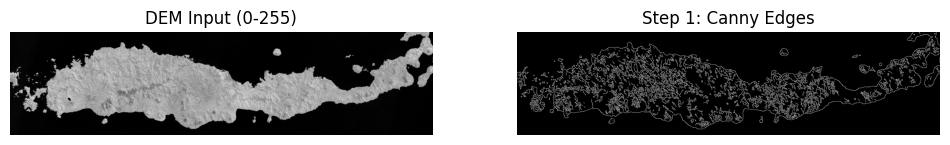

In [35]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("DEM Input (0-255)")
plt.imshow(pc1_byte, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Step 1: Canny Edges")
plt.imshow(pc1_edges, cmap='gray')
plt.axis('off')

plt.show()

Running Hough Transform (Length=4, Gap=9)...
Found 5866 lineaments.


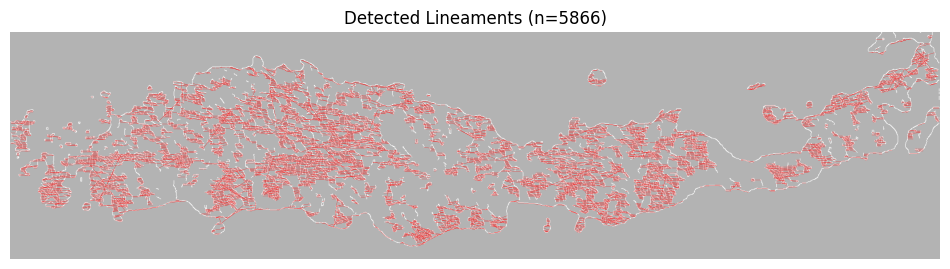

In [36]:
#L9 PCA to canny

# --- PARAMETERS (Based on your PCI reference) ---
# LTHR: Minimum length of a line (in pixels). 
# If a line is shorter than this, it is deleted.
pci_lthr = 4

# DTHR: Maximum gap between two parts of a line to still link them.
# If the gap is bigger than this, it counts as two separate lines.
pci_dthr = 9

# Threshold: Minimum number of pixels that must "vote" for a line.
# Lower this if you are missing faint lines.
hough_threshold = 2

#To lock the random prob hough results
seed = 67

print(f"Running Hough Transform (Length={pci_lthr}, Gap={pci_dthr})...")

# 1. Run the Algorithm
# Input: The binary 'edges' image from the Canny step

pc1_lines = probabilistic_hough_line(pc1_edges,
                                 threshold=hough_threshold, 
                                 line_length=pci_lthr, 
                                 line_gap=pci_dthr,
                                 rng = seed)

print(f"Found {len(pc1_lines)} lineaments.")

# 2. Visualization
# We will draw the detected vector lines ON TOP of the original DEM edges
plt.figure(figsize=(12, 12))

# Show the Canny Edges as a faint background
plt.imshow(pc1_edges, cmap='gray', alpha=0.3)

# Plot the extracted vectors
# print("Plotting lines...")
for line in pc1_lines:
    p0, p1 = line
    # p0 and p1 are (col, row) coordinates -> (x, y)
    # plt.plot expects ([x1, x2], [y1, y2])
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]), color='red', linewidth=0.15)

plt.title(f"Detected Lineaments (n={len(pc1_lines)})")
plt.axis('off')
plt.show()

Original Lines: 5866
Filtered Lines (Non-Horizontal): 206
Params: DTHR = 9 , LTHR = 4 , HTHR = 2 canny_sigma = 1 canny_low_threshold = 40 canny_high_threshold = 75


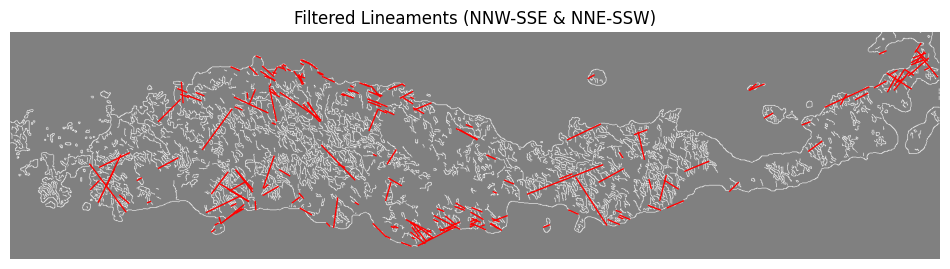

In [37]:
import math

def filter_lines_by_angle(lines, min_angle_deg, max_angle_deg):
    """
    Keeps lines that fall within a specific angular range.
    0 degrees = Horizontal (West-East)
    90 degrees = Vertical (North-South)
    """
    kept_lines = []
    for p0, p1 in lines:
        x1, y1 = p0
        x2, y2 = p1
        
        # Calculate angle in degrees (0 to 180)
        if x2 - x1 == 0: # Vertical line
            angle = 90
        else:
            # Calculate slope and convert to degrees
            slope = (y2 - y1) / (x2 - x1)
            angle = abs(math.degrees(math.atan(slope)))
        
        # Logic: We want to DELETE Horizontal lines (near 0)
        # We only keep lines that are steeper than min_angle (e.g., > 20 degrees)
        if min_angle_deg <= angle <= max_angle_deg:
            kept_lines.append((p0, p1))
            
    return kept_lines

# 2. Apply the "Geologist Filter"
# We reject anything within 20 degrees of horizontal (0-20 and 160-180)
# We keep anything from 20 degrees up to 90 degrees (Steep/Vertical)
filtered_lines = filter_lines_by_angle(pc1_lines, min_angle_deg=20, max_angle_deg=90)

print(f"Original Lines: {len(pc1_lines)}")
print(f"Filtered Lines (Non-Horizontal): {len(filtered_lines)}")
print("Params: DTHR =", pci_dthr, ", LTHR =", pci_lthr, ", HTHR =", hough_threshold, "canny_sigma =", canny_sigma, "canny_low_threshold =", low_threshold, "canny_high_threshold =", high_threshold)

# 3. Visualization
plt.figure(figsize=(12, 6))
plt.imshow(pc1_edges, cmap='gray', alpha=0.5)
plt.title("Filtered Lineaments (NNW-SSE & NNE-SSW)")

for p0, p1 in filtered_lines:
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]), color='red', linewidth=1)

plt.gca()
plt.axis('off')
plt.show()

1. Rasterizing 206 lineaments...
2. Calculating Density (Kernel Radius: 33 pixels / 4 km)...


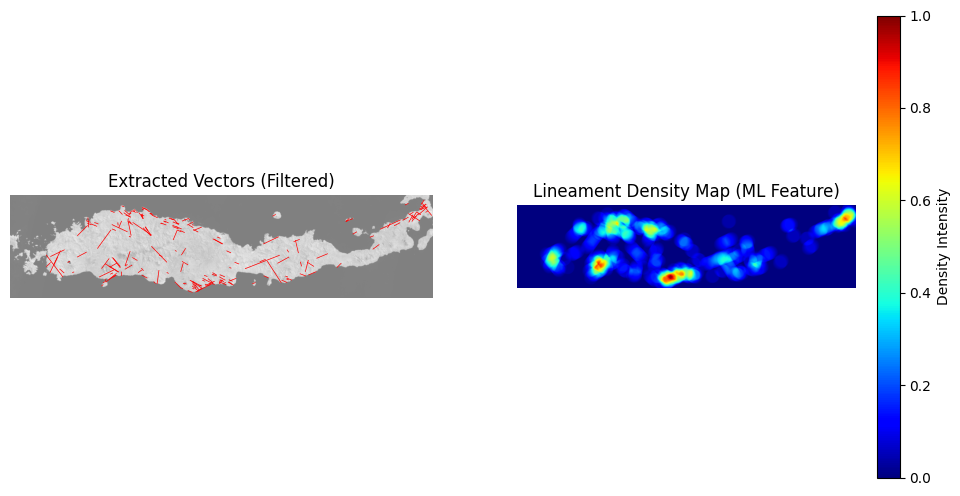

In [40]:
#Line to densitymap
from skimage.draw import line
from scipy.ndimage import convolve

radius_km = 4
pixel_size_m = 120

def generate_density_map(lines, shape, radius_km, pixel_size_m):
    """
    Converts vector lines to a Lineament Density Raster (Heatmap).
    """
    # 1. Create a blank raster (zeros)
    line_raster = np.zeros(shape, dtype=np.float32)
    
    print(f"1. Rasterizing {len(lines)} lineaments...")
    
    # 2. Burn lines into the raster
    # filtered_lines format is ((x0, y0), (x1, y1)) -> ((col, row), (col, row))
    for p0, p1 in lines:
        c0, r0 = int(p0[0]), int(p0[1]) # x is col, y is row
        c1, r1 = int(p1[0]), int(p1[1])
        
        # skimage.draw.line takes (row0, col0, row1, col1)
        rr, cc = line(r0, c0, r1, c1)
        
        # Boundary check to prevent crashing on edge pixels
        valid = (rr >= 0) & (rr < shape[0]) & (cc >= 0) & (cc < shape[1])
        line_raster[rr[valid], cc[valid]] = 1.0

    # 3. Create the Density Kernel (Circular Window)
    # We want a radius of 'radius_km'
    radius_px = int((radius_km * 1000) / pixel_size_m)
    print(f"2. Calculating Density (Kernel Radius: {radius_px} pixels / {radius_km} km)...")
    
    # Create a circular mask of 1s
    y, x = np.ogrid[-radius_px:radius_px+1, -radius_px:radius_px+1]
    kernel = x**2 + y**2 <= radius_px**2
    kernel = kernel.astype(np.float32)
    
    # Normalize kernel? 
    # If we want "Length per Area", we sum the pixels. 
    # If we want "Intensity", we can normalize.
    # For ML, raw counts (Sum) usually works best as a feature.
    
    # 4. Convolve (The Moving Window)
    # This sums up all 'line pixels' found within the circle for every pixel in the map
    density_map = convolve(line_raster, kernel, mode='constant', cval=0.0)
    
    return density_map

# --- EXECUTION ---

# Define resolution (Critical for correct kernel size)
# You mentioned earlier you downloaded PC1 at scale=60
#CURRENT_SCALE = 120

# Generate the map
# Radius=2km is standard for regional geothermal fault analysis
density_map = generate_density_map(filtered_lines, pc1_byte.shape, radius_km, pixel_size_m)

# Normalize Density to 0-1 range for the ML Model
# (Helps the model learn faster)
density_norm = (density_map - density_map.min()) / (density_map.max() - density_map.min())

# --- VISUALIZATION ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Extracted Vectors (Filtered)")
plt.imshow(pc1_byte, cmap='gray', alpha=0.5)
for p0, p1 in filtered_lines:
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]), color='red', linewidth=0.5)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Lineament Density Map (ML Feature)")
plt.imshow(density_norm, cmap='jet') # Jet/Magma is good for heatmaps
plt.colorbar(label="Density Intensity")
plt.axis('off')

plt.show()

1. Fetching LST and DEM arrays...
Done fetching images. Downloading arrays...
Done downloading arrays.
2. Calculating Regression...
   -> Removed 4232 outlier pixels (Cold/Low).
   -> Points remaining for regression: 257764
   -> Regression Equation: LST = (-0.0083 * Elevation) + 35.07
   -> Slope (Lapse Rate): -8.31 °C/km
   -> R-squared: 0.5325
Done downloading arrays.
2. Calculating Regression...
   -> Removed 4232 outlier pixels (Cold/Low).
   -> Points remaining for regression: 257764
   -> Regression Equation: LST = (-0.0083 * Elevation) + 35.07
   -> Slope (Lapse Rate): -8.31 °C/km
   -> R-squared: 0.5325


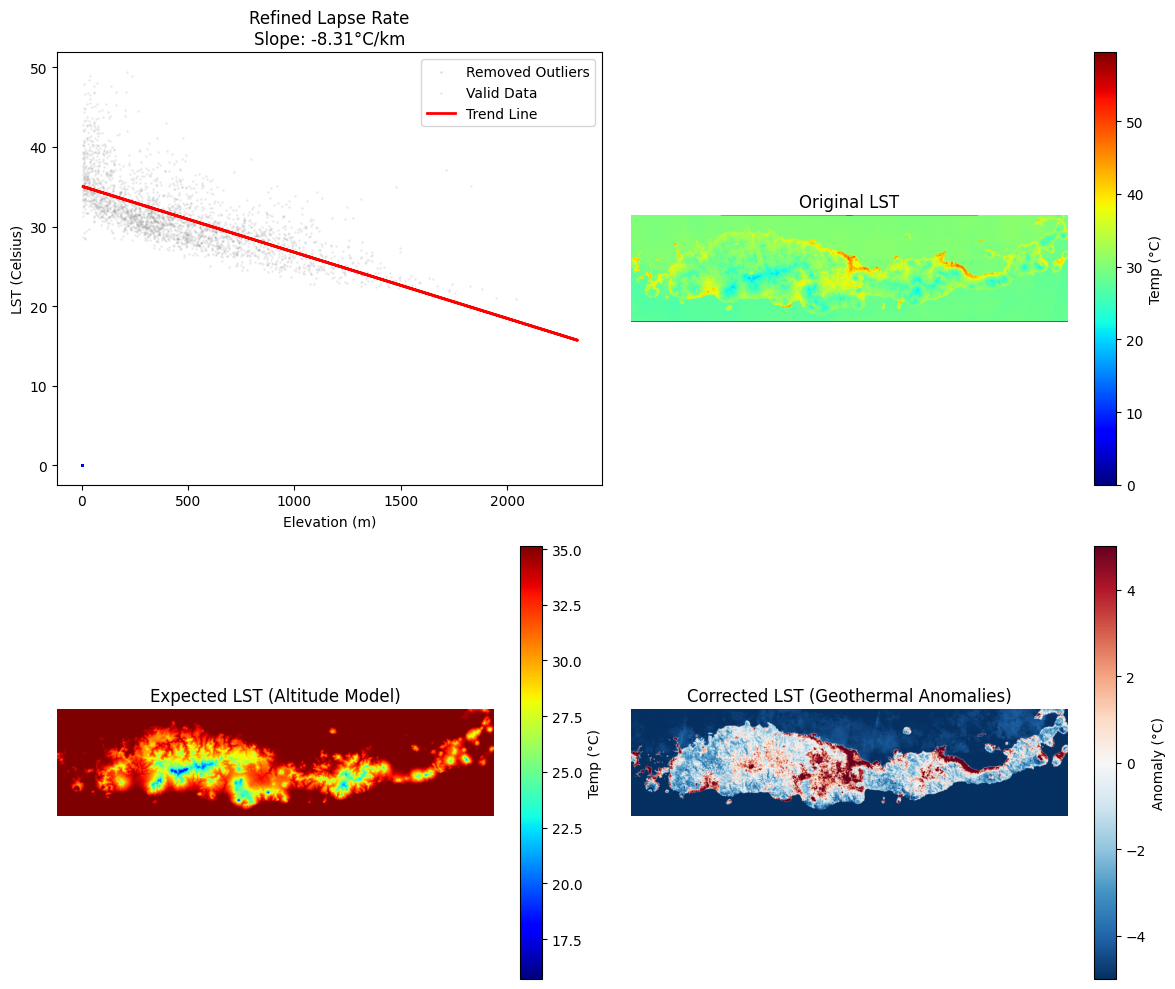

In [41]:
#LapseRate
from scipy import stats

# --- STEP 1: Fetch Data (If you don't have them as arrays yet) ---
# We use the same scale (60m) to ensure they match pixel-for-pixel
print("1. Fetching LST and DEM arrays...")

# Using your 'final_map_layer' from previous steps
lst_image = final_composite.select('LST_Celsius')
dem_image = final_map_layer.select('DEM')
combined_image = lst_image.addBands(dem_image)

print("Done fetching images. Downloading arrays...")

# Download to NumPy
stack_array = geemap.ee_to_numpy(combined_image, region=roi, scale=240)

print("Done downloading arrays.")

# Handle 3D shape (H, W, 1) -> (H, W)
lst_array = stack_array[:, :, 0]
dem_array = stack_array[:, :, 1]

# --- STEP 2: Pre-process for Regression ---
print("2. Calculating Regression...")

# Flatten the arrays to 1D lists so we can plot X vs Y
flat_dem = dem_array.flatten()
flat_lst = lst_array.flatten()

# Filter out NaNs (Clouds/Ocean)
# We only want to train the regression on valid pixels
valid_mask = ~np.isnan(flat_dem) & ~np.isnan(flat_lst)
is_cold_low_altitude = (flat_dem < 200) & (flat_lst < 25) 

# Apply the filter: Keep valid pixels that are NOT "Cold Low"
final_mask = valid_mask & ~is_cold_low_altitude

# Extra Safety: Remove Sea Level entirely (often causes noise)
final_mask = final_mask & (flat_dem > 5)

x_clean = flat_dem[final_mask] # Altitude (X)
y_clean = flat_lst[final_mask] # Temperature (Y)

print(f"   -> Removed {np.sum(is_cold_low_altitude)} outlier pixels (Cold/Low).")
print(f"   -> Points remaining for regression: {len(x_clean)}")

# --- STEP 3: Linear Regression (Same as before) ---
slope, intercept, r_value, p_value, std_err = stats.linregress(x_clean, y_clean)

print(f"   -> Regression Equation: LST = ({slope:.4f} * Elevation) + {intercept:.2f}")
print(f"   -> Slope (Lapse Rate): {slope*1000:.2f} °C/km")
print(f"   -> R-squared: {r_value**2:.4f}")

# --- STEP 4: Apply Correction ---
# Note: We apply the correction to the WHOLE map (lst_array), not just the filtered pixels.
lst_expected = (dem_array * slope) + intercept
lst_corrected = lst_array - lst_expected

# --- VISUALIZATION ---
plt.figure(figsize=(12, 10))

# Plot 1: The Regression Scatter Plot (Cleaned)
plt.subplot(2, 2, 1)
# Plot the REJECTED points in Blue (so you can see what you removed)
rejected_x = flat_dem[is_cold_low_altitude]
rejected_y = flat_lst[is_cold_low_altitude]
plt.scatter(rejected_x[::10], rejected_y[::10], alpha=0.1, s=1, color='blue', label='Removed Outliers')

# Plot the ACCEPTED points in Gray
plt.scatter(x_clean[::100], y_clean[::100], alpha=0.1, s=1, color='gray', label='Valid Data')

plt.plot(x_clean, slope*x_clean + intercept, color='red', label='Trend Line', linewidth=2)
plt.xlabel('Elevation (m)')
plt.ylabel('LST (Celsius)')
plt.title(f'Refined Lapse Rate\nSlope: {slope*1000:.2f}°C/km')
plt.legend()

# Plot 2: Original LST
plt.subplot(2, 2, 2)
plt.imshow(lst_array, cmap='jet')
plt.title('Original LST')
plt.colorbar(label='Temp (°C)')
plt.axis('off')

# Plot 3: Expected LST
plt.subplot(2, 2, 3)
plt.imshow(lst_expected, cmap='jet')
plt.title('Expected LST (Altitude Model)')
plt.colorbar(label='Temp (°C)')
plt.axis('off')

# Plot 4: Corrected LST
plt.subplot(2, 2, 4)
plt.imshow(lst_corrected, cmap='RdBu_r', vmin=-5, vmax=5)
plt.title('Corrected LST (Geothermal Anomalies)')
plt.colorbar(label='Anomaly (°C)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [49]:
from skimage.transform import resize
import pandas as pd
# --- STEP 1: Download GEE Features to Disk (Bypasses RAM Limit) ---
print("1. Starting Tiled Download for GEE Features...")

# Define bands to download
gee_features = final_map_layer.select(['SMI', 'NDVI', 'NDWI', 'DEM'])

# Output file
out_stack = 'D:\\GeothermalRevamp\\gee_features_final.tif'

geemap.download_ee_image(
    gee_features,
    filename=out_stack,
    scale=240,       # You can use 240 (fast) or 60 (high res) - it won't crash now!
    region=roi,
    crs='EPSG:4326',
    scale_offset=True # Keeps raw float values
)

print("✅ Download Complete.")

# --- STEP 2: Load GEE Data & Resize Local Data ---
print("2. reconciling array dimensions...")

with rasterio.open(out_stack) as src:
    # Read the downloaded bands
    smi_arr = src.read(1)
    ndvi_arr = src.read(2)
    ndwi_arr = src.read(3)
    dem_arr = src.read(4)
    
    # This is the Master Shape everything must match
    TARGET_SHAPE = dem_arr.shape
    print(f"   Target Shape (from GEE): {TARGET_SHAPE}")

# Function to resize local arrays to match the GEE download
def match_shape(arr, target_shape):
    return resize(arr, target_shape, order=1, preserve_range=True).astype(np.float32)

# Resize your local arrays (LST_Corrected and Lineament Density)
# Note: Ensure 'lst_corrected' and 'density_norm' exist in your variable list!
lst_corr_aligned = match_shape(lst_corrected, TARGET_SHAPE)

# --- STEP 3: Create Final Stack ---
print("3. Stacking features...")

# Stack Order:
# 0: LST Corrected (Geothermal Anomaly)
# 1: Lineament Density (Permeability)
# 2: SMI (Soil Moisture)
# 3: NDVI (Vegetation)
# 4: NDWI (Water)
# 5: DEM (Topo Context)

feature_stack = np.dstack([
    lst_corr_aligned,  
    smi_arr, 
    ndvi_arr, 
    ndwi_arr, 
    dem_arr
])

# Handle NaNs (Replace with -9999 for XGBoost safety)
feature_stack = np.nan_to_num(feature_stack, nan=-9999)

print(f"✅ FINAL STACK READY: {feature_stack.shape}")

# --- STEP 4: Preview Data ---
X_data = feature_stack.reshape(-1, 5)
df = pd.DataFrame(X_data, columns=['LST_Corr', 'SMI', 'NDVI', 'NDWI', 'DEM'])

print("\nData Statistics:")
print(df.describe().loc[['mean', 'min', 'max', 'std']])

1. Starting Tiled Download for GEE Features...


  0%|          |0/8 tiles [00:00<?]

✅ Download Complete.
2. reconciling array dimensions...
   Target Shape (from GEE): (397, 1625)
3. Stacking features...
✅ FINAL STACK READY: (397, 1625, 5)

Data Statistics:
✅ FINAL STACK READY: (397, 1625, 5)

Data Statistics:
       LST_Corr            SMI           NDVI           NDWI            DEM
mean  -3.649773           -inf           -inf           -inf           -inf
min  -35.069778 -1.797693e+308 -1.797693e+308 -1.797693e+308 -1.797693e+308
max   24.694412   9.766554e-01   9.990338e-01   9.995854e-01   2.330000e+03
std    4.314198            inf            inf            inf            inf
       LST_Corr            SMI           NDVI           NDWI            DEM
mean  -3.649773           -inf           -inf           -inf           -inf
min  -35.069778 -1.797693e+308 -1.797693e+308 -1.797693e+308 -1.797693e+308
max   24.694412   9.766554e-01   9.990338e-01   9.995854e-01   2.330000e+03
std    4.314198            inf            inf            inf            inf


In [61]:
import geopandas as gpd
from rasterio import features

# --- CONFIGURATION ---
shapefile_path = "C:\\Tugas\\Sem 8\\TA\\label_shp.shp" # Update this!
reference_tif = out_stack # From previous step

# 1. Load Data
print("1. Loading Shapefile and Reference Grid...")
gdf = gpd.read_file(shapefile_path)

# --- 2. Create IDs if missing ---
# We need a unique number for every polygon to group them correctly
if 'id' not in gdf.columns:
    print("Creating 'id' column for polygons...")
    gdf['id'] = range(len(gdf))

# --- 3. Get Reference Info (Grid) ---
with rasterio.open(reference_tif) as src:
    ref_shape = src.shape
    ref_transform = src.transform
    ref_crs = src.crs

if gdf.crs != ref_crs:
    gdf = gdf.to_crs(ref_crs)

# --- 4. Rasterize Groups (The Missing Step) ---
print("Rasterizing Polygon Groups...")

# Generator for rasterize function
shapes_id = ((geom, value) for geom, value in zip(gdf.geometry, gdf['id']))

# Burn IDs into a grid (-1 is background)
group_array = features.rasterize(
    shapes_id, 
    out_shape=ref_shape, 
    transform=ref_transform, 
    fill=-1, 
    dtype=np.int32
)

# --- 5. Match with Training Data ---
# We need to recreate the valid_mask to ensure groups match X_train exactly
# (Assuming label_array was created in your previous step. If not, we re-create it quickly)
shapes_label = ((geom, value) for geom, value in zip(gdf.geometry, gdf['Label']))
label_array = features.rasterize(
    shapes_label, 
    out_shape=ref_shape, 
    transform=ref_transform, 
    fill=-9999, 
    dtype=np.float32
)

y_all = label_array.flatten()
groups_all = group_array.flatten()

# The mask used to create X_train
valid_mask = (y_all != -9999)

# Create the missing variable
groups_train = groups_all[valid_mask]

print(f"✅ FIXED: 'groups_train' created with shape {groups_train.shape}")
print(f"   (Must match X_train: {X_train.shape[0]})")

# We must overwrite the old X_train with the new 5-band feature_stack

print("Refreshing X_train with new 5-band stack...")

# 1. Flatten the NEW feature_stack (5 bands)
rows, cols, bands = feature_stack.shape
X_all = feature_stack.reshape(rows * cols, bands)

# 2. Use the valid_mask (calculated in your Label/Group block)
# This ensures X and y align perfectly
X_train = X_all[valid_mask]

print(f"✅ X_train Refreshed.")
print(f"   New Shape: {X_train.shape} (Should be N pixels x 5 features)")

1. Loading Shapefile and Reference Grid...
Rasterizing Polygon Groups...
✅ FIXED: 'groups_train' created with shape (4011,)
   (Must match X_train: 4011)
Refreshing X_train with new 5-band stack...
✅ X_train Refreshed.
   New Shape: (4011, 5) (Should be N pixels x 5 features)


Starting Hyperparameter Tuning (this may take a few minutes)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

🏆 Best Parameters: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.7}
🏆 Best CV Score: 0.2911

🏆 Best Parameters: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.7}
🏆 Best CV Score: 0.2911


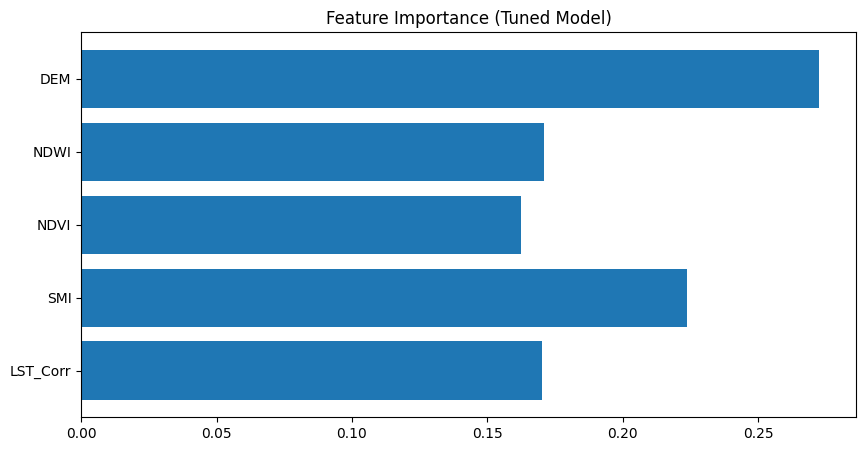

['D:\\GeothermalRevamp\\geothermal_xgboost_TUNED.joblib']

In [62]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GroupKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import joblib

# 1. Define the Parameter Grid (What to tune)
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],           # Deeper = more complex (risk of overfitting)
    'subsample': [0.6, 0.7, 0.8, 0.9],   # Lower = less overfitting
    'colsample_bytree': [0.6, 0.7, 0.8],
    'gamma': [0, 0.1, 0.2]               # Minimum loss reduction to split
}

# 2. Setup GroupKFold
# 5 Splits means: Train on 4/5ths of Polygons, Test on 1/5th. Repeat 5 times.
gkf = GroupKFold(n_splits=5)

# 3. Initialize Model
xgb_model = xgb.XGBClassifier(random_state=42, n_jobs=-1)

# 4. Setup Random Search
print("Starting Hyperparameter Tuning (this may take a few minutes)...")
search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,           # Try 20 different random combinations
    scoring='f1',        # Optimize for F1 Score (Balance of Precision/Recall)
    cv=gkf,              # Use our Spatial Groups!
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 5. Fit (Notice we pass 'groups' here!)
search.fit(X_train, y_train, groups=groups_train)

# --- RESULTS ---
print(f"\n🏆 Best Parameters: {search.best_params_}")
print(f"🏆 Best CV Score: {search.best_score_:.4f}")

# The 'best_estimator_' is the fully trained model with the best params
best_model = search.best_estimator_

# 6. Feature Importance Check
feature_names = ['LST_Corr', 'SMI', 'NDVI', 'NDWI', 'DEM']
plt.figure(figsize=(10, 5))
plt.barh(feature_names, best_model.feature_importances_)
plt.title("Feature Importance (Tuned Model)")
plt.show()

# 7. Save
joblib.dump(best_model, 'D:\\GeothermalRevamp\\geothermal_xgboost_TUNED.joblib')

1. Predicting Geothermal Potential across Flores...
   Using Tuned Model (best_model)
✅ Prediction completed with strict threshold: 0.95
2. Plotting Maps...


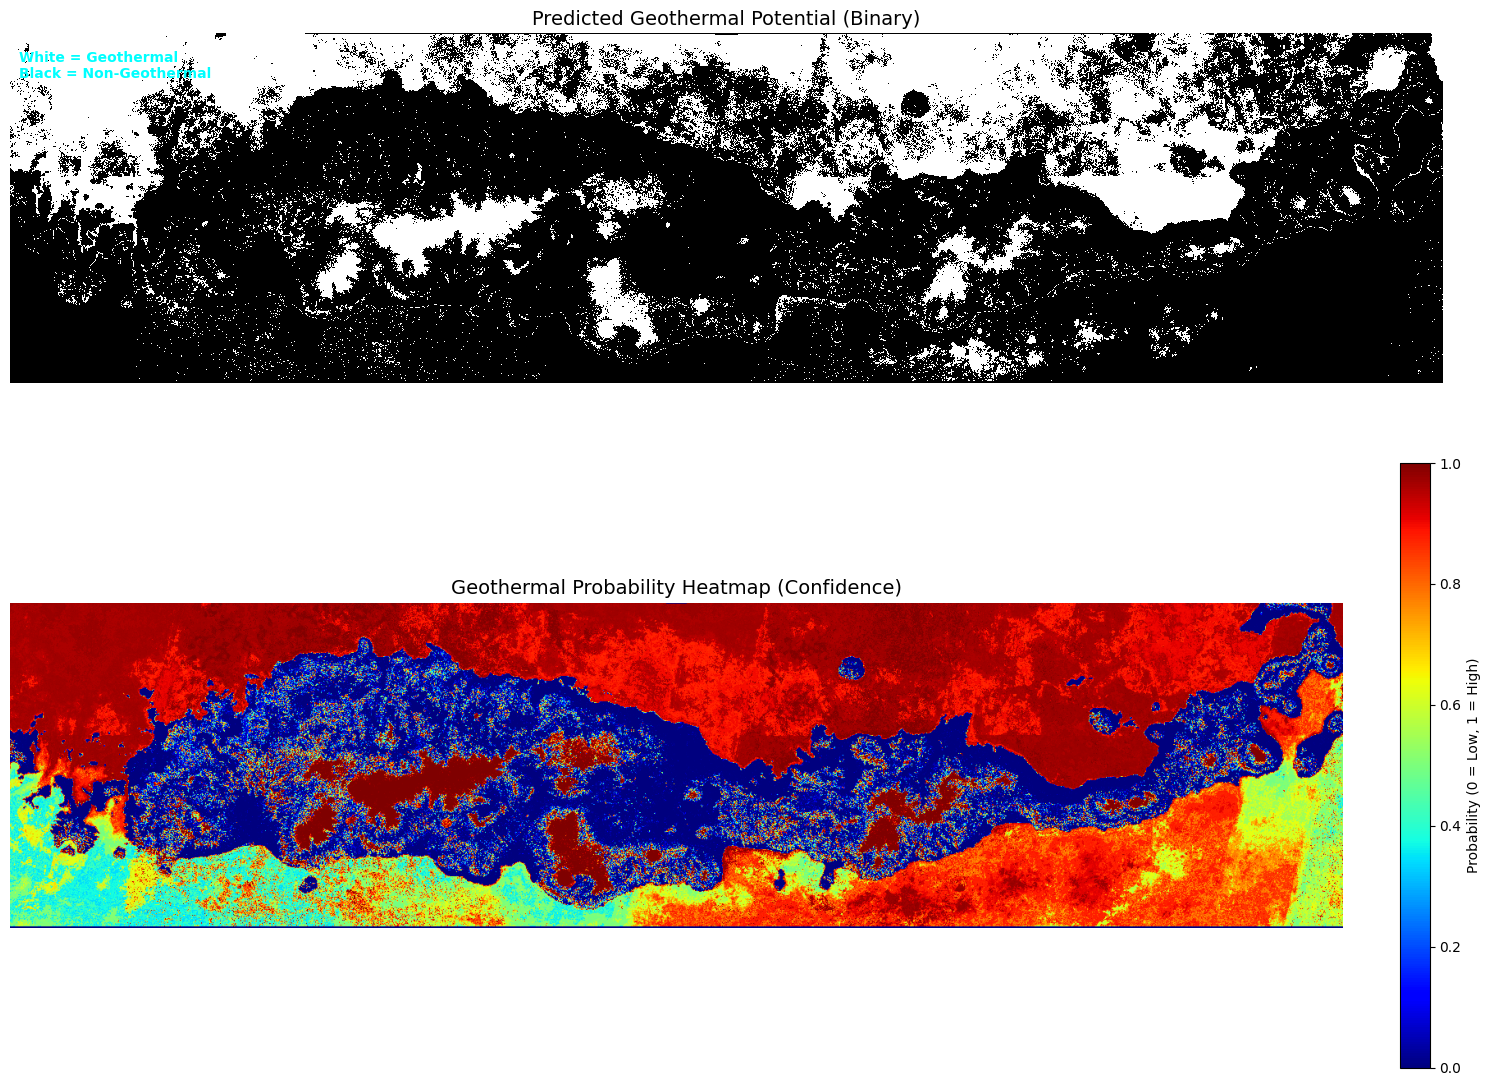


3. Saving Probability Map to: D:\GeothermalRevamp\Flores_Geothermal_Prediction.tif
✅ Map Saved successfully!


In [68]:
# --- STEP 1: Generate Predictions ---
print("1. Predicting Geothermal Potential across Flores...")

# Ensure X_all exists (created in previous data prep steps)
# We use the best model found by the Random Search
# (If you didn't run tuning, change 'best_model' to 'model')
try:
    target_model = best_model
    print("   Using Tuned Model (best_model)")
except NameError:
    target_model = model
    print("   Using Standard Model (model)")

# 1. Get the probability (confidence) score for every pixel
# [:, 1] selects the probability of Class 1 (Geothermal)
proba_flat = target_model.predict_proba(X_all)[:, 1]

# 2. Apply your CUSTOM Threshold (e.g., 0.8)
# If prob > 0.8, make it 1. Otherwise, make it 0.
strict_threshold = 0.95
pred_flat = (proba_flat > strict_threshold).astype(int)

print(f"✅ Prediction completed with strict threshold: {strict_threshold}")

# --- STEP 2: Reshape to Map Dimensions ---
# We use ref_shape from the rasterio step to know the map size
prediction_map = pred_flat.reshape(ref_shape)
probability_map = proba_flat.reshape(ref_shape)

# --- STEP 3: Visualization ---
print("2. Plotting Maps...")

plt.figure(figsize=(15, 12))

# Plot A: The Binary Prediction (The "Hard" Decision)
plt.subplot(2, 1, 1)
plt.title("Predicted Geothermal Potential (Binary)", fontsize=14)
plt.imshow(prediction_map, cmap='gray', interpolation='nearest')
# Add a custom legend or text
plt.text(10, 50, "White = Geothermal\nBlack = Non-Geothermal", color='cyan', fontsize=10, fontweight='bold')
plt.axis('off')

# Plot B: The Probability Heatmap (The "Soft" Confidence)
plt.subplot(2, 1, 2)
plt.title("Geothermal Probability Heatmap (Confidence)", fontsize=14)
# 'jet' or 'magma' are great for heatmaps. 
# We mask the background (-9999 areas) if needed, but X_all handles it.
im = plt.imshow(probability_map, cmap='jet', vmin=0, vmax=1)
plt.colorbar(im, label="Probability (0 = Low, 1 = High)", fraction=0.03, pad=0.04)
plt.axis('off')

plt.tight_layout()
plt.show()

# --- OPTIONAL: Save the Result as a GeoTIFF ---
# This allows you to open the result in QGIS/ArcGIS!
import rasterio

out_tif = "D:\\GeothermalRevamp\\Flores_Geothermal_Prediction.tif"
print(f"\n3. Saving Probability Map to: {out_tif}")

with rasterio.open(
    out_tif,
    'w',
    driver='GTiff',
    height=ref_shape[0],
    width=ref_shape[1],
    count=1,
    dtype=probability_map.dtype,
    crs=ref_crs,
    transform=ref_transform,
) as dst:
    dst.write(probability_map, 1)

print("✅ Map Saved successfully!")